# Session 8 : Change-point and anomaly detection

>Intelligence Artificielle & Machine Learning pour la modélisation de séries temporelles et de signaux<br />
>Master 1 Parcours IA ENS Paris Saclay<br />
>Laurent Oudre (laurent.oudre@ens-paris-saclay.fr)

This eigth and last session is dedicated to change-point detection and anomaly detection in time series. Slides are available at http://www.laurentoudre.fr/signalml.html

<div class="alert alert-block alert-info">
    
1. **Library  loading**
2. **Change-point detection**
3. **Anomaly detection** 
</div>

## 1. Library loading

In [1]:
%matplotlib notebook
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal
from scipy import stats
from statsmodels.tsa.ar_model import AutoReg
import ruptures as rpt

In [2]:
plt.rcParams['figure.figsize'] = (8,5)

## 2. Change-point detection

Given a time series $\mathbf{x}$, the aim of change-point detection is to retrieve the locations $\mathcal{T}^* = \left( t^*_1, \ldots, t^*_{K^*}\right) $ of the $K^*$ change point occuring in the signal.

### 2.1. Data loading and exploratory study

In [3]:
from loadmydata.load_uea_ucr import load_uea_ucr_data
dataset_name = "UMD"
data = load_uea_ucr_data(dataset_name)
X=np.array(data.X_train)
x=X[0,:,0]
x=np.reshape(x,(len(x),1))
print(data.description)

# UMD dataset

UMD is a synthetic data set with 3 classes: one class is characterized by a small up bell arising at the initial or final period (Up); one does not have any bell (Middle); one has a small down bell arising at the initial or final period (Down).

- Class 1: Up
- Class 2: Middle
- Class 3: Down

Train size: 36

Test size: 144

Missing value: No

Number of classses: 3

Time series length: 150

Data source: UniversitÃ© Joseph Fourier (Grenoble I), Laboratoire dâinformatique de Grenoble(LIG), Equipe AMA



<IPython.core.display.Javascript object>


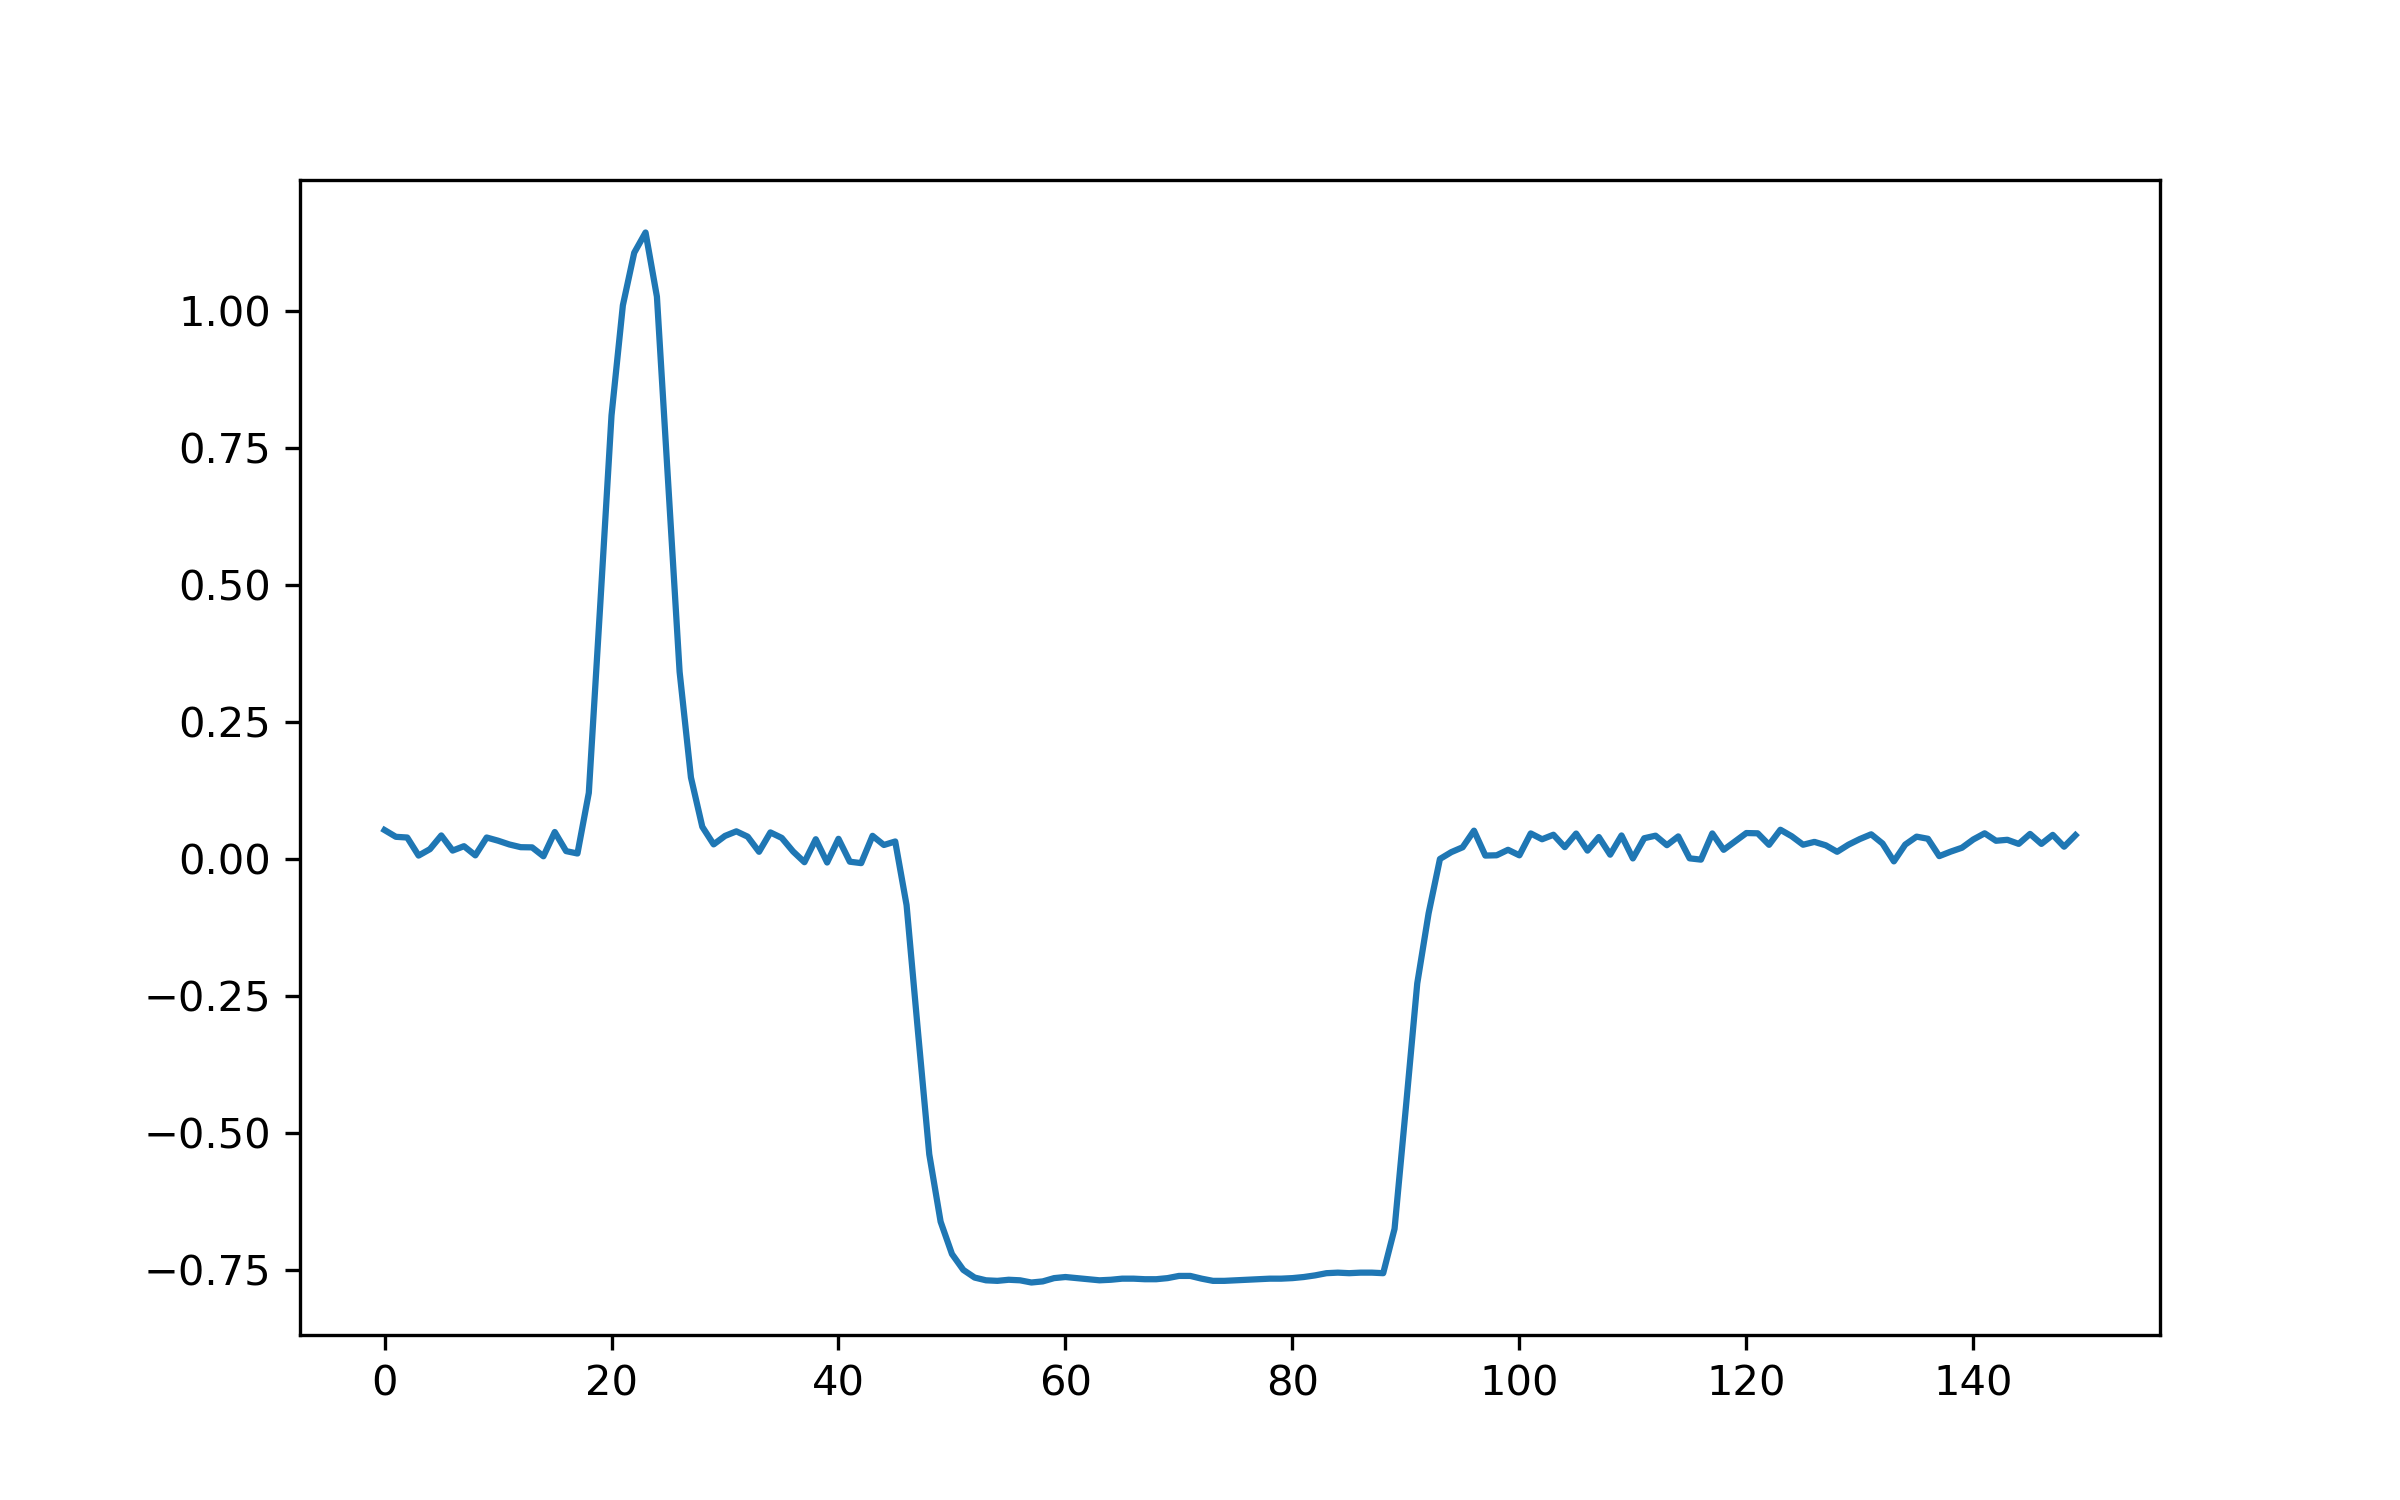

In [4]:
# Plot of the input signal
plt.figure("Input signal")
plt.plot(x)
plt.show()

### 2.2. Change point detection with known K

When the number of breakpoints $K^*$ is unknown, this problem can be seen as an optimization problem
$$\left( \hat{t}_1, \ldots, \hat{t}_{K}\right)  = \underset{\left( t_1, \ldots, t_{K}\right)}{\operatorname{argmin}} \sum_{k=0}^{K} \ c(x[t_{k}..t_{k+1}])$$
This problem can be solved through dynamic programming and relies on a cost function $c(.)$ that determines the type of changes that we seek to find in the signal. Popular choice is the $L_2$ norm : $c(.) = \| . \|_2^2$, but several other cost functions can be used (see the <a href="https://dev.ipol.im/~truong/ruptures-docs/build/html/costs/index.html">documentation of the ruptures package</a>)

<IPython.core.display.Javascript object>


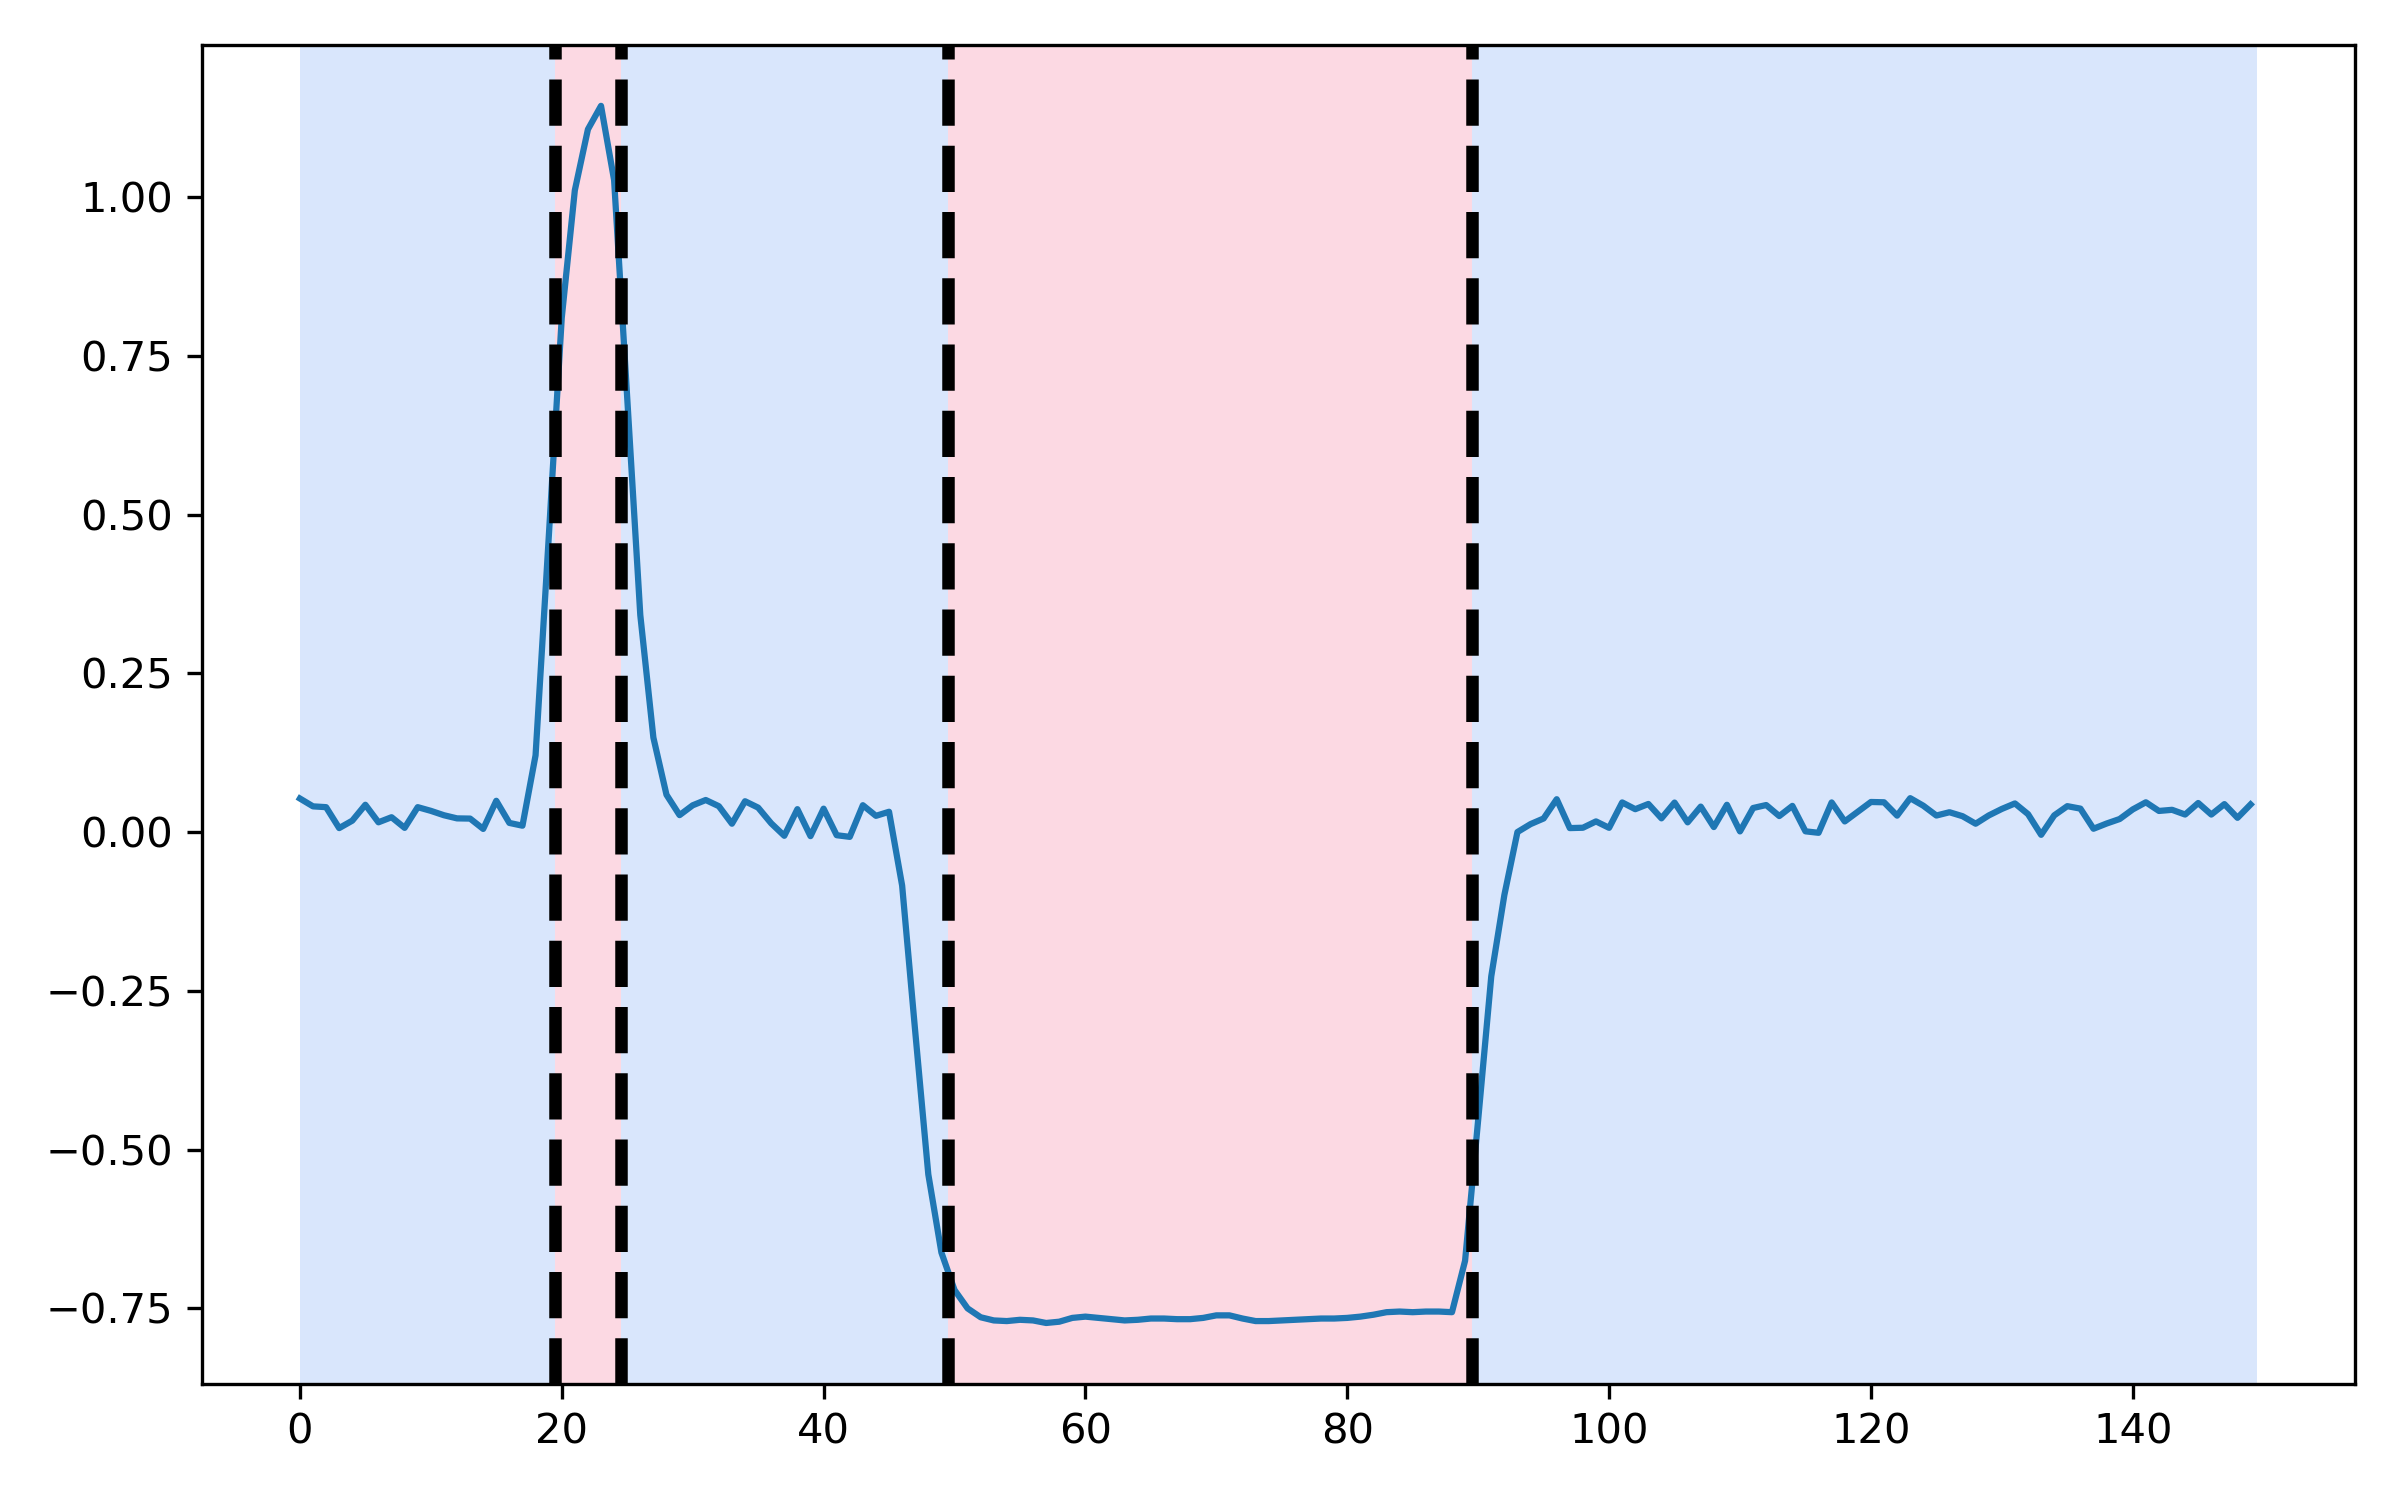

In [6]:
# Change point detection with L2 cost function and K=3 breakpoints 
K=4 #Number of breakpoints
algo = rpt.Dynp(model='l2', min_size=3).fit(x)
my_bkps = algo.predict(n_bkps=K)
rpt.show.display(x, my_bkps , my_bkps, figsize=(8, 5))
plt.show()

[45, 150]
[45, 90, 150]
[30, 50, 90, 150]
[20, 25, 50, 90, 150]
[20, 25, 45, 50, 90, 150]
[20, 25, 30, 45, 50, 90, 150]
[20, 25, 30, 45, 50, 90, 95, 150]
[15, 20, 25, 30, 45, 50, 90, 95, 150]
[15, 20, 25, 30, 45, 50, 85, 90, 95, 150]
[15, 20, 25, 30, 35, 45, 50, 85, 90, 95, 150]


<IPython.core.display.Javascript object>


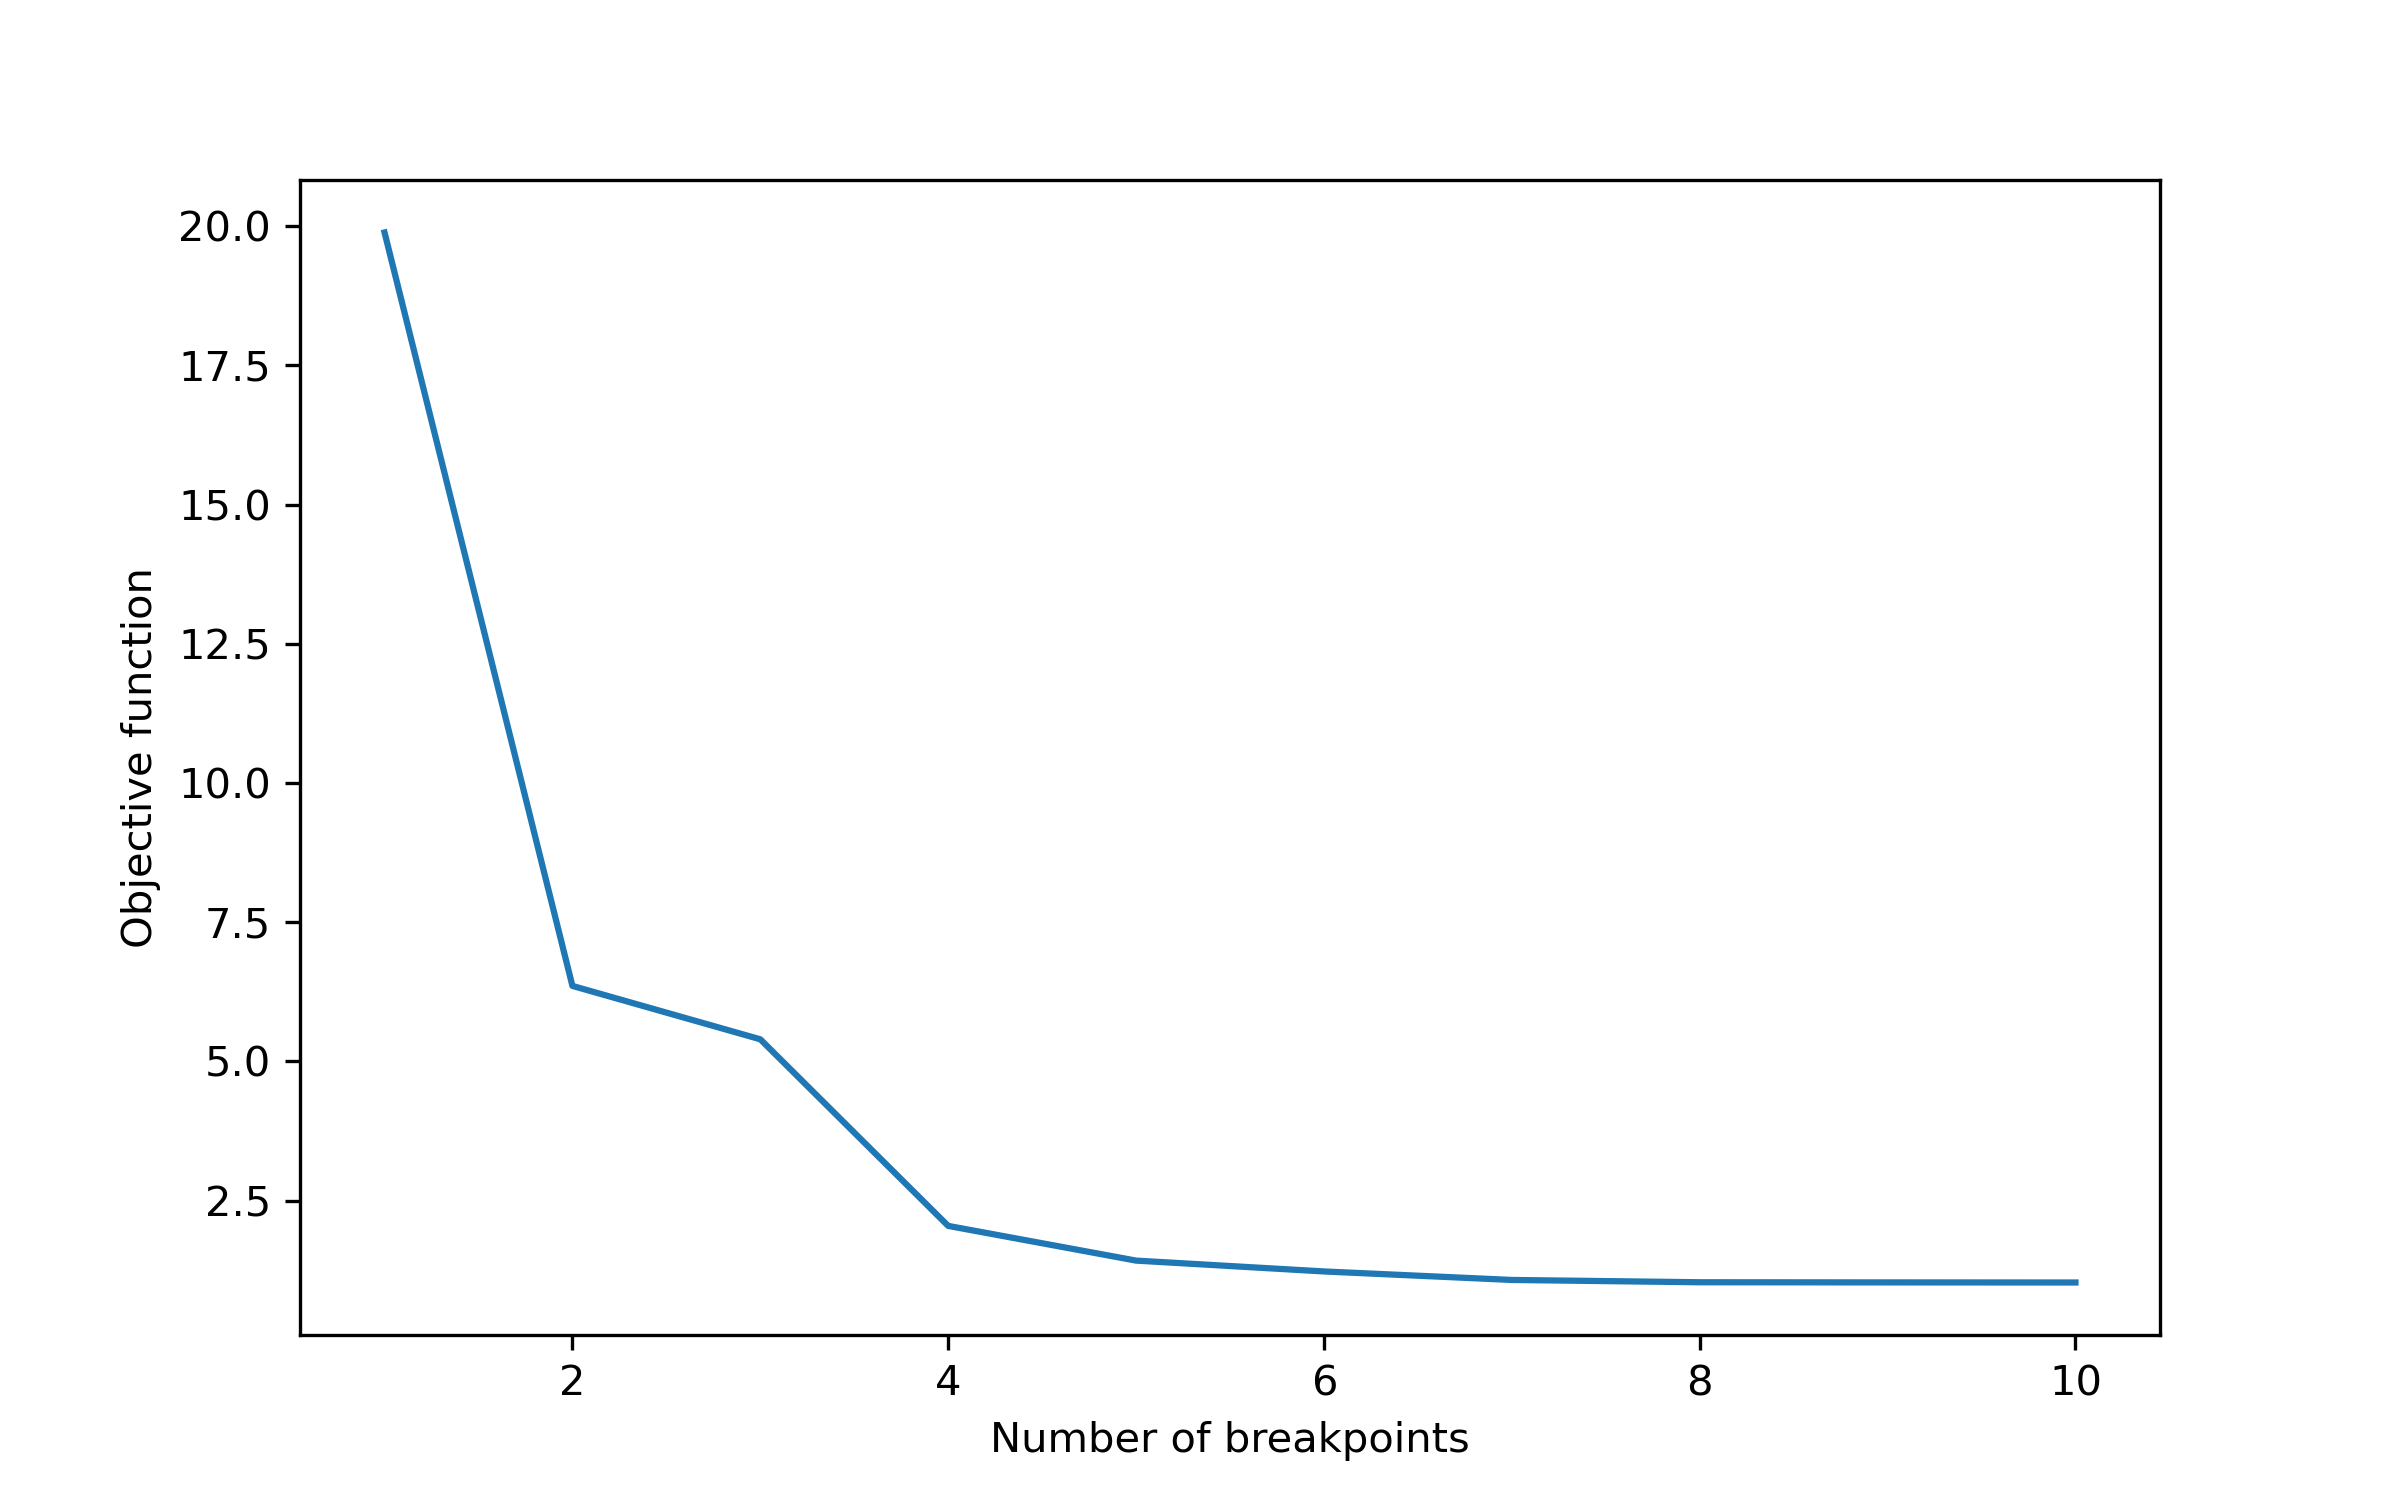

In [7]:
# Plot of the optimization criterion as a function of the number of breakpoints
c=rpt.costs.CostL2().fit(x)
algo = rpt.Dynp(model="l2", min_size=3).fit(x)
Nk=10
cout=np.zeros((Nk,))
for k in range(Nk):
    my_bkps = algo.predict(n_bkps=k+1)
    print(my_bkps)
    cout[k]=c.sum_of_costs(my_bkps)
k=np.arange(1,Nk+1)
plt.figure("Objective function as a function of the number of breakpoints")
plt.plot(k,cout)
plt.xlabel("Number of breakpoints")
plt.ylabel("Objective function")
plt.show()

### 2.3. Change point detection with unknown K

When the number of change-points is unknown, another optimization problem can be computed. The penalized problem offers a compromise between the minimization of the sum of costs and the number of breakpoints (algorithm PELT).  

$$\left( \hat{t}_1, \ldots, \hat{t}_{\hat{K}}\right)  = \underset{\left( t_1, \ldots, t_{K}\right), K}{\operatorname{argmin}} \sum_{k=0}^{K} \ c(x[t_{k}:t_{k+1}]) + \beta K$$

<IPython.core.display.Javascript object>


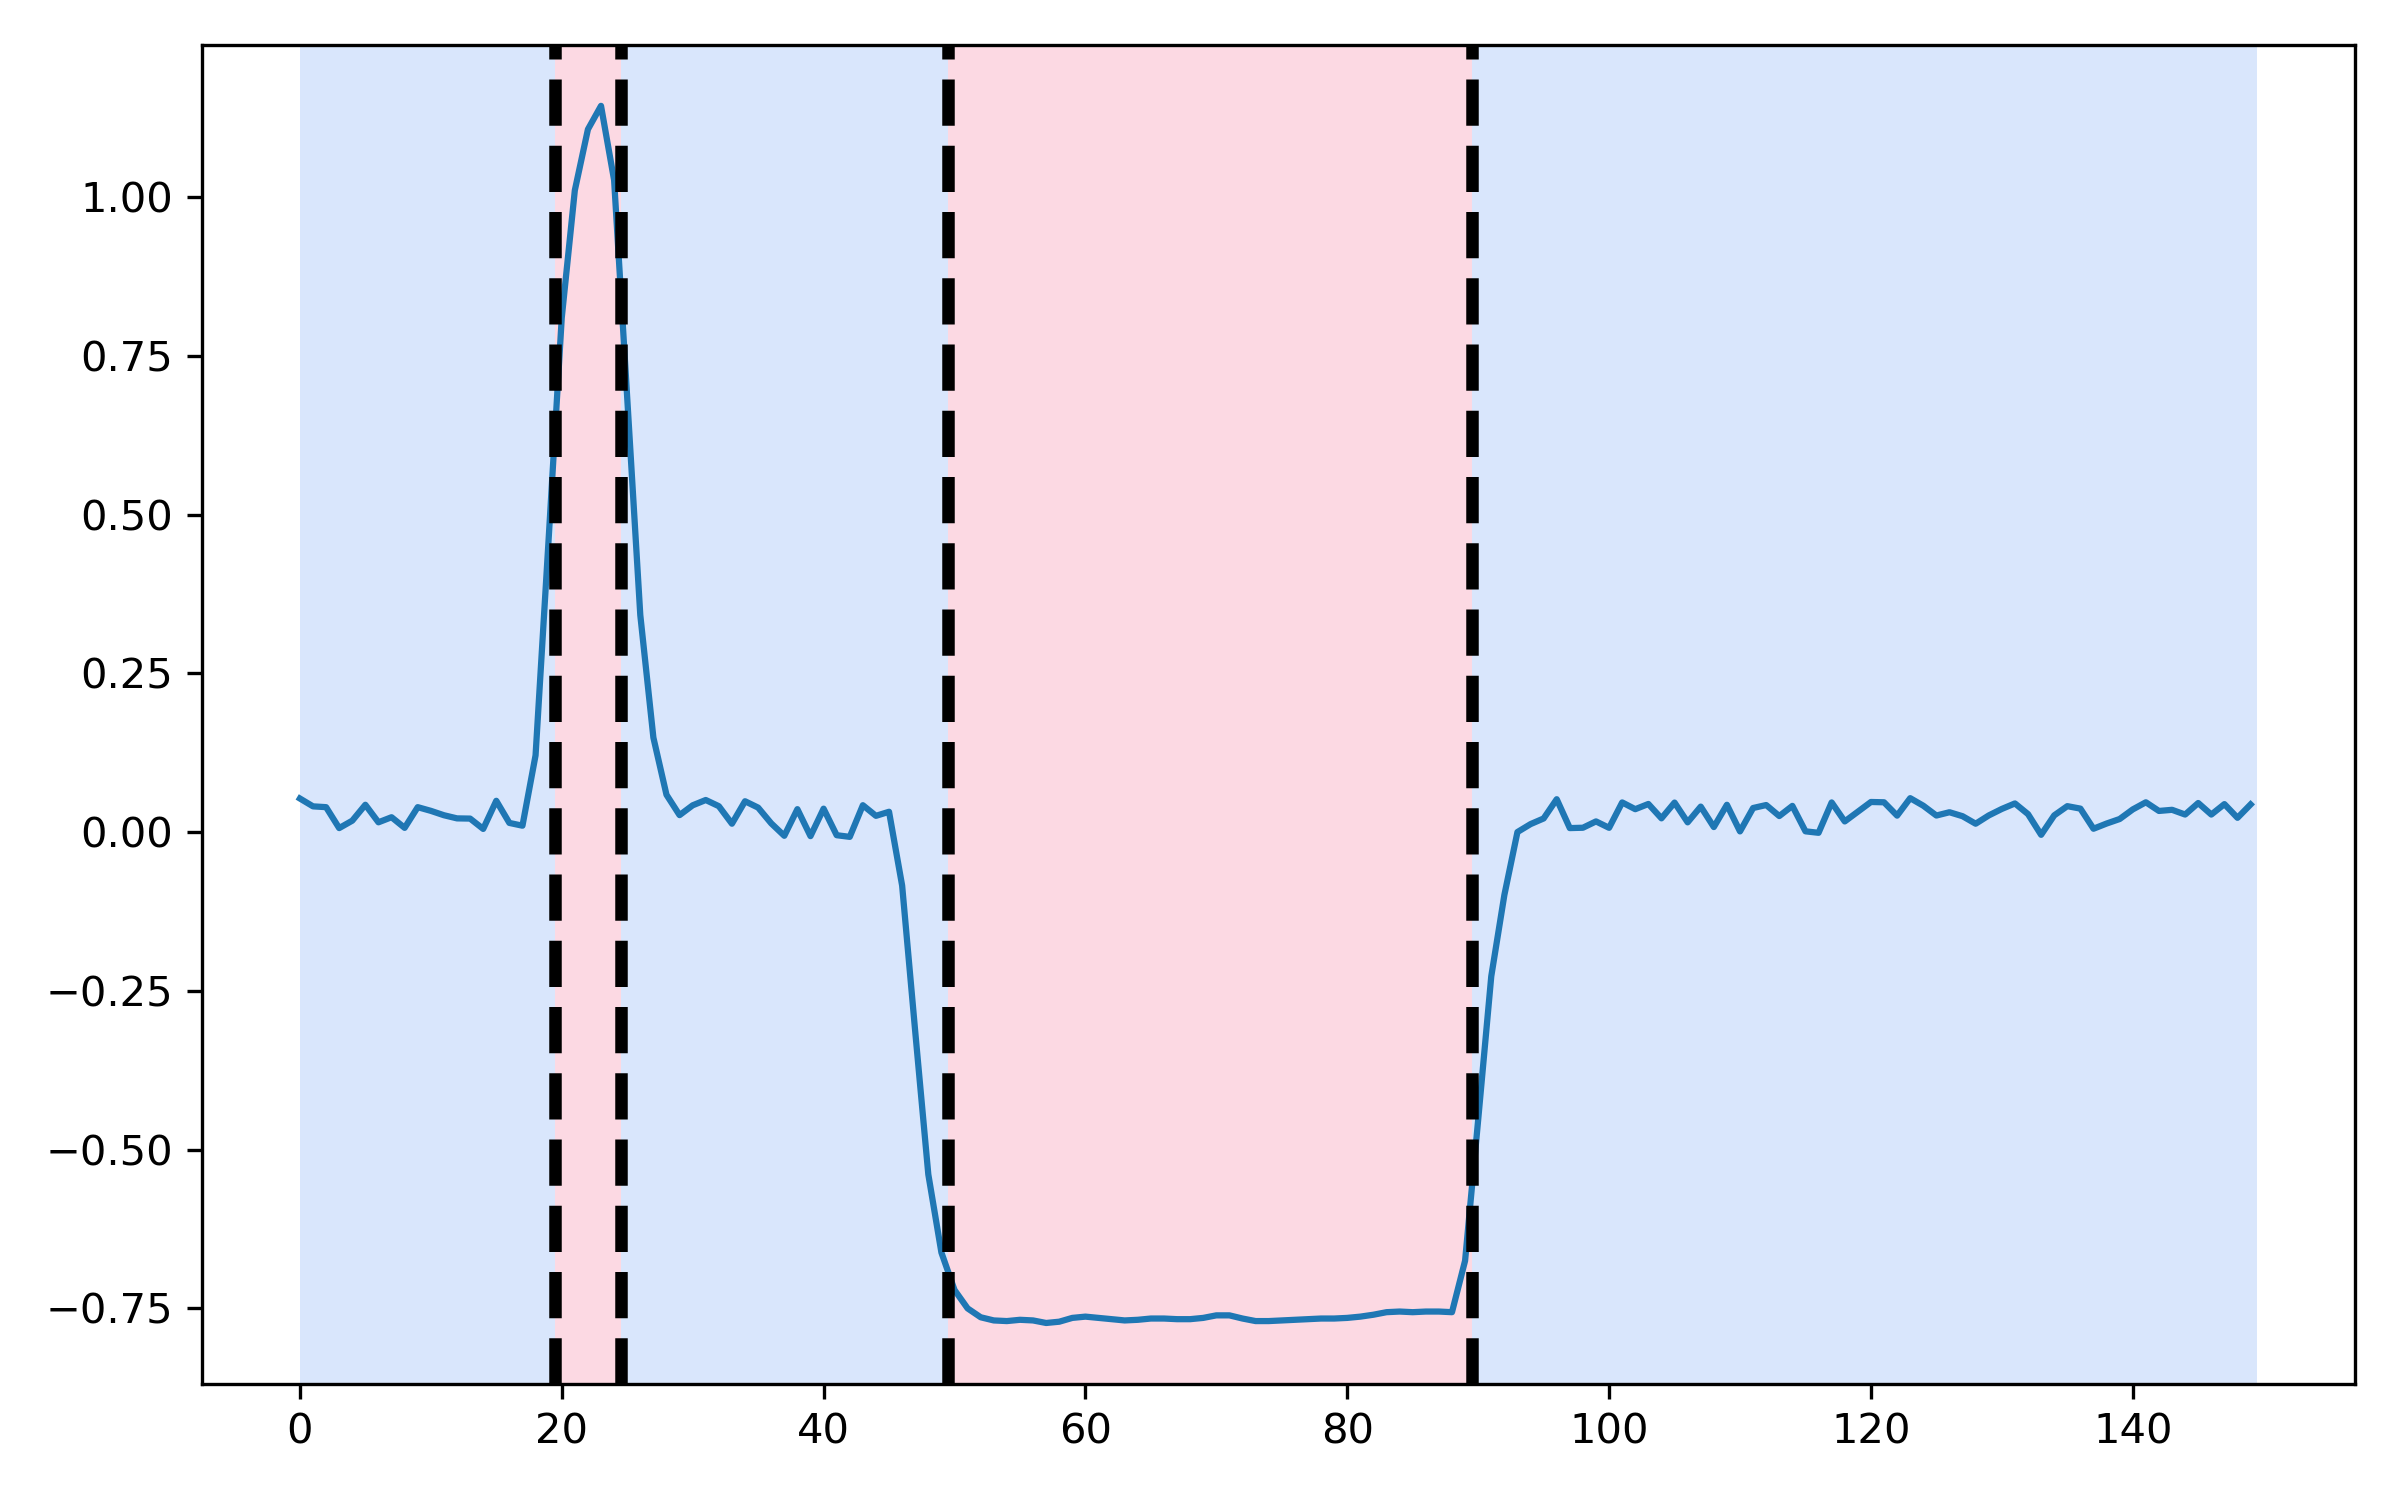

In [8]:
# PELT change point detection with L2 cost function 
pen=1 #Penalization
algo = rpt.Pelt(model='l2', min_size=3).fit(x)
my_bkps = algo.predict(pen=pen)
rpt.show.display(x, my_bkps , my_bkps, figsize=(8, 5))
plt.show()

## 3. Anomaly detection

The task of anomaly detection consists in finding the set of unusual or outliers samples in a time series. Several techniques can be used depending on the definition given to the notion of anomaly.

### 3.1. Data loading and exploratory study

In [9]:
# Data loading
from loadmydata.load_nyc_taxi import load_nyc_taxi_dataset
X, y, description = load_nyc_taxi_dataset()
print(description)

X=np.array(X)
dates=X[:,0]
x=X[:,1].astype(float)
N=len(x)
Fs=1/1800

This data set contains the number of New York taxi passengers aggregated in 30 minutes buckets for the period between July 2014 and January 2015. There are five anomalies occur during the NYC marathon, Thanksgiving, Christmas, New Years day, and a snow storm.

The raw data is from the NYC Taxi and Limousine Commission [1] and has been curated by [2].

[1]: https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page 
[2]: Ahmad, S., Lavin, A., Purdy, S., & Agha, Z. (2017). Unsupervised real-time anomaly detection for streaming data. Neurocomputing.


### 3.2. Model-based anomaly detection

In [10]:
# Learn AR parameters with p equal to one week
p=7*24*2
model = AutoReg(x, lags=p,old_names=False)
model_fit = model.fit()

<IPython.core.display.Javascript object>


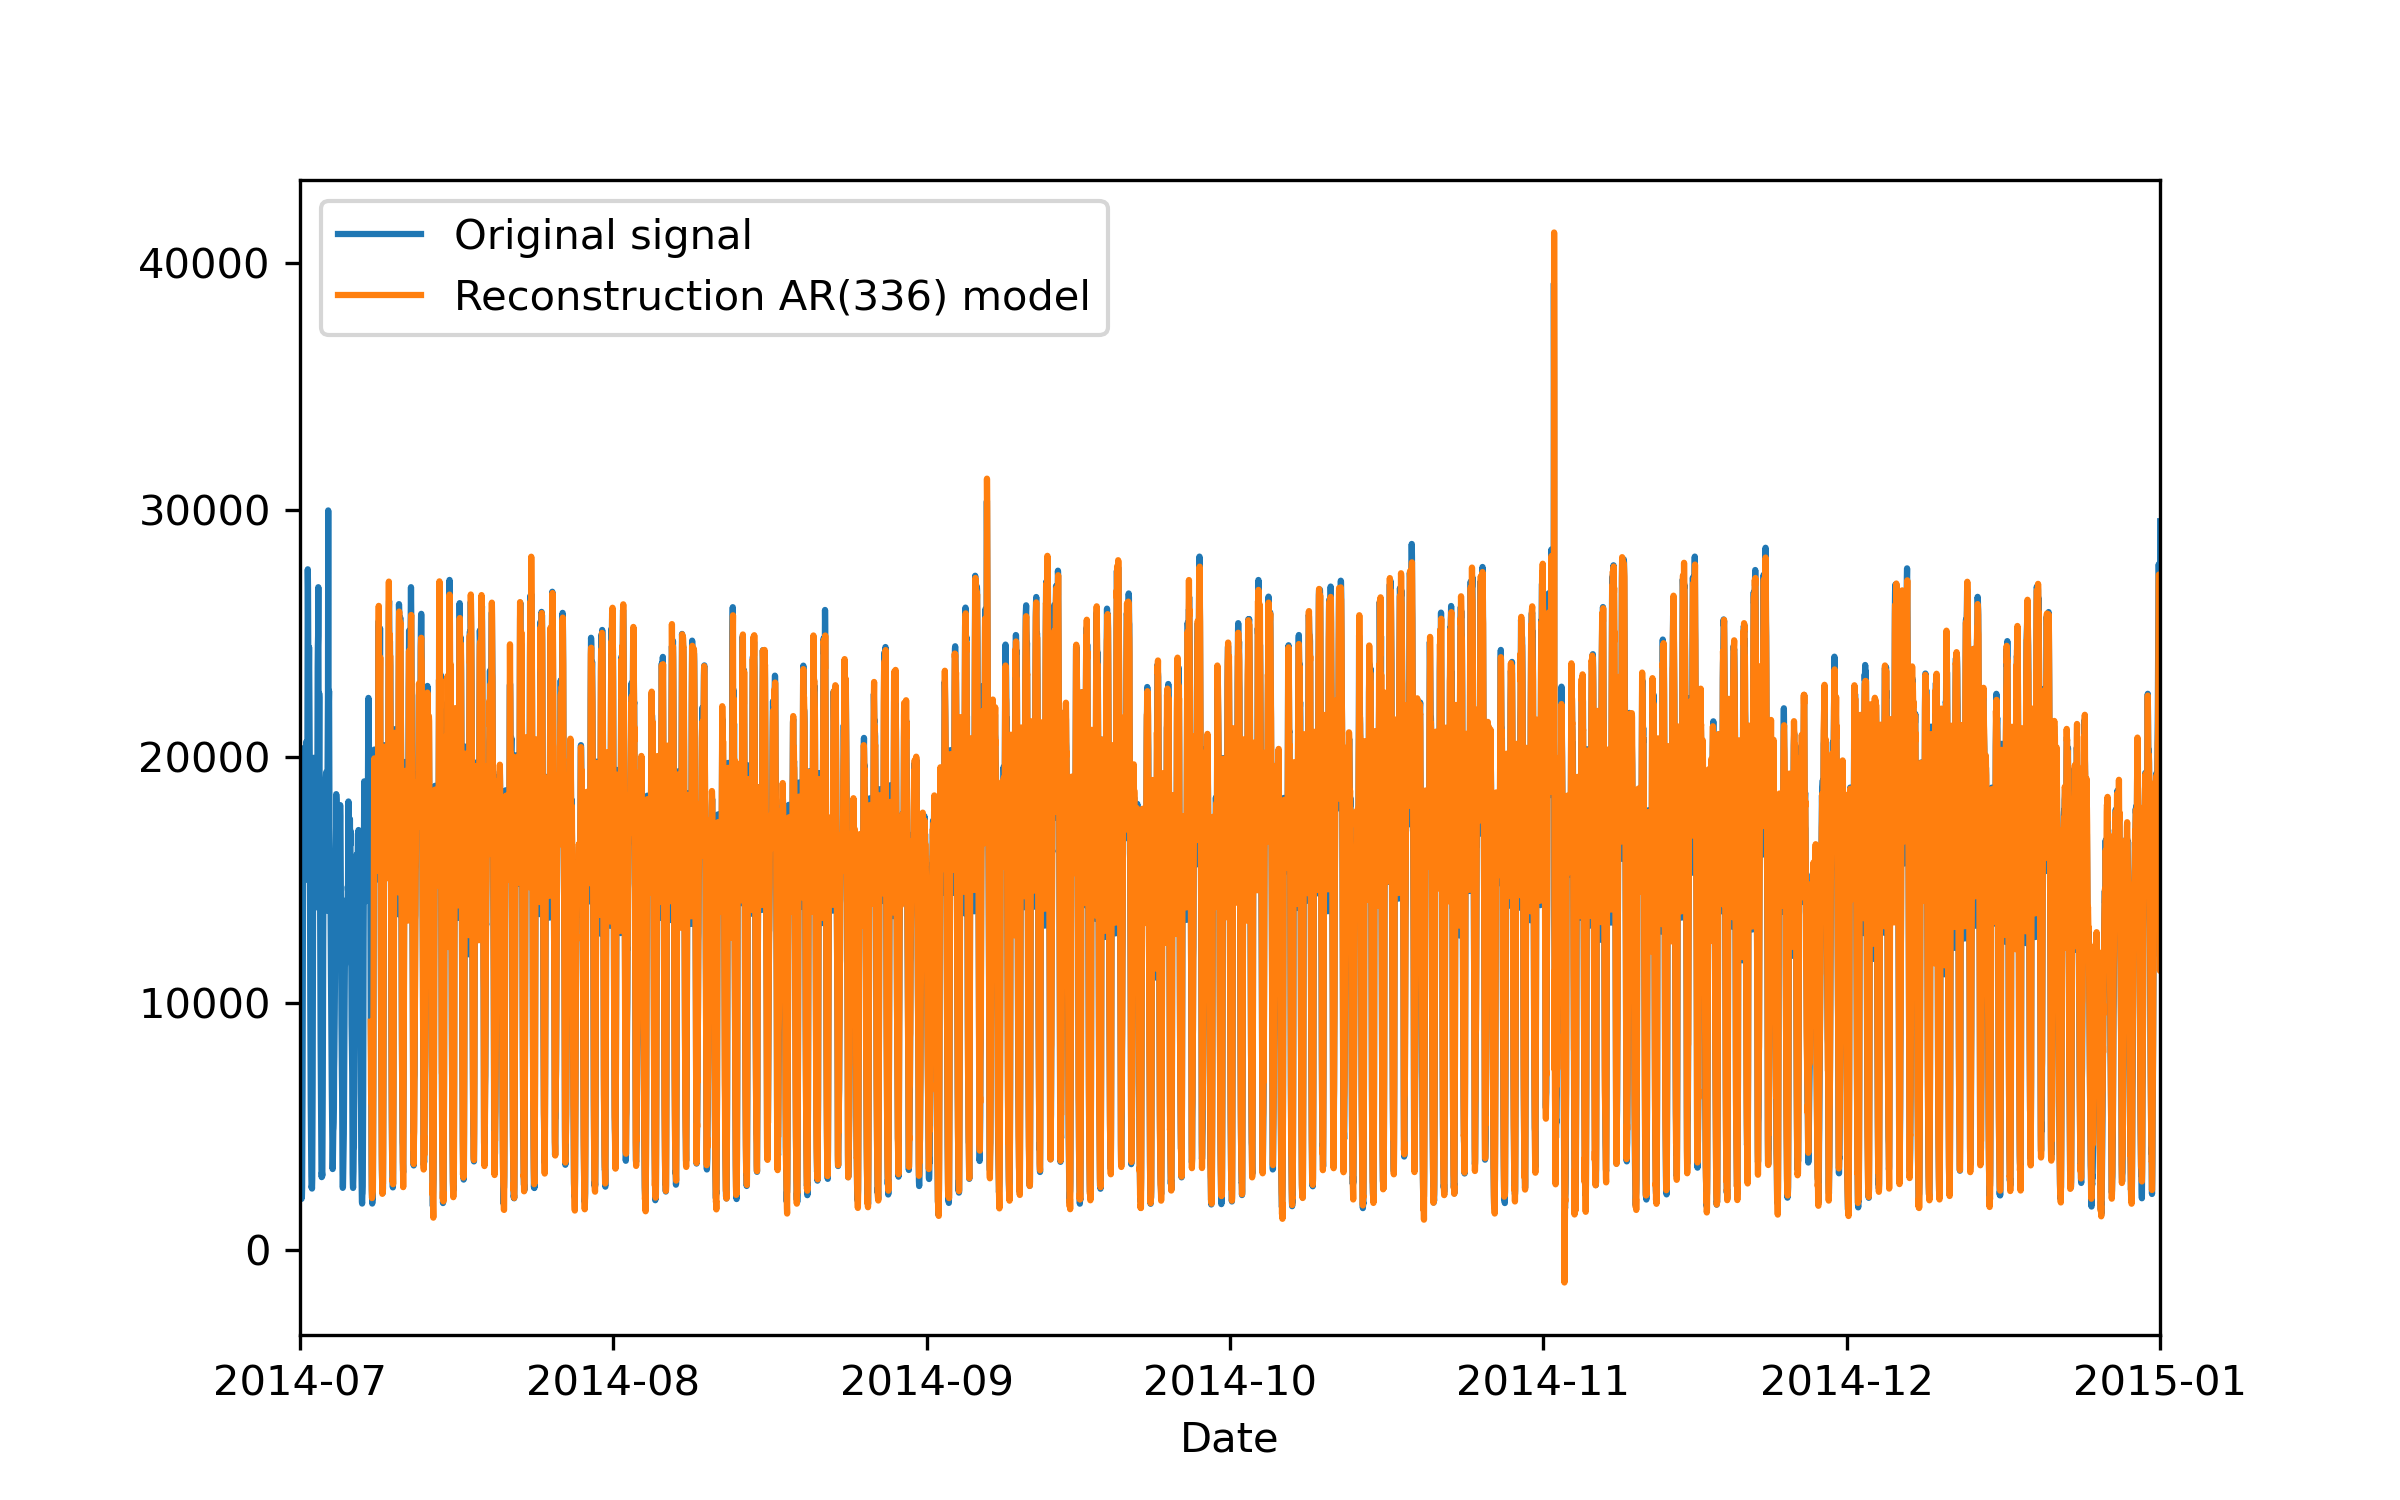

In [11]:
# Reconstruction with the AR model
x_hat = model_fit.predict()
plt.figure("Reconstruction with the AR(336) model")
plt.plot(dates,x)
plt.plot(dates[p:],x_hat)
datemin = np.datetime64(dates[0], 'M')
datemax = np.datetime64(dates[-1], 'M')
plt.xlim((datemin,datemax))
plt.xlabel('Date')
plt.legend(('Original signal', 'Reconstruction AR(336) model'))
plt.show()

<IPython.core.display.Javascript object>


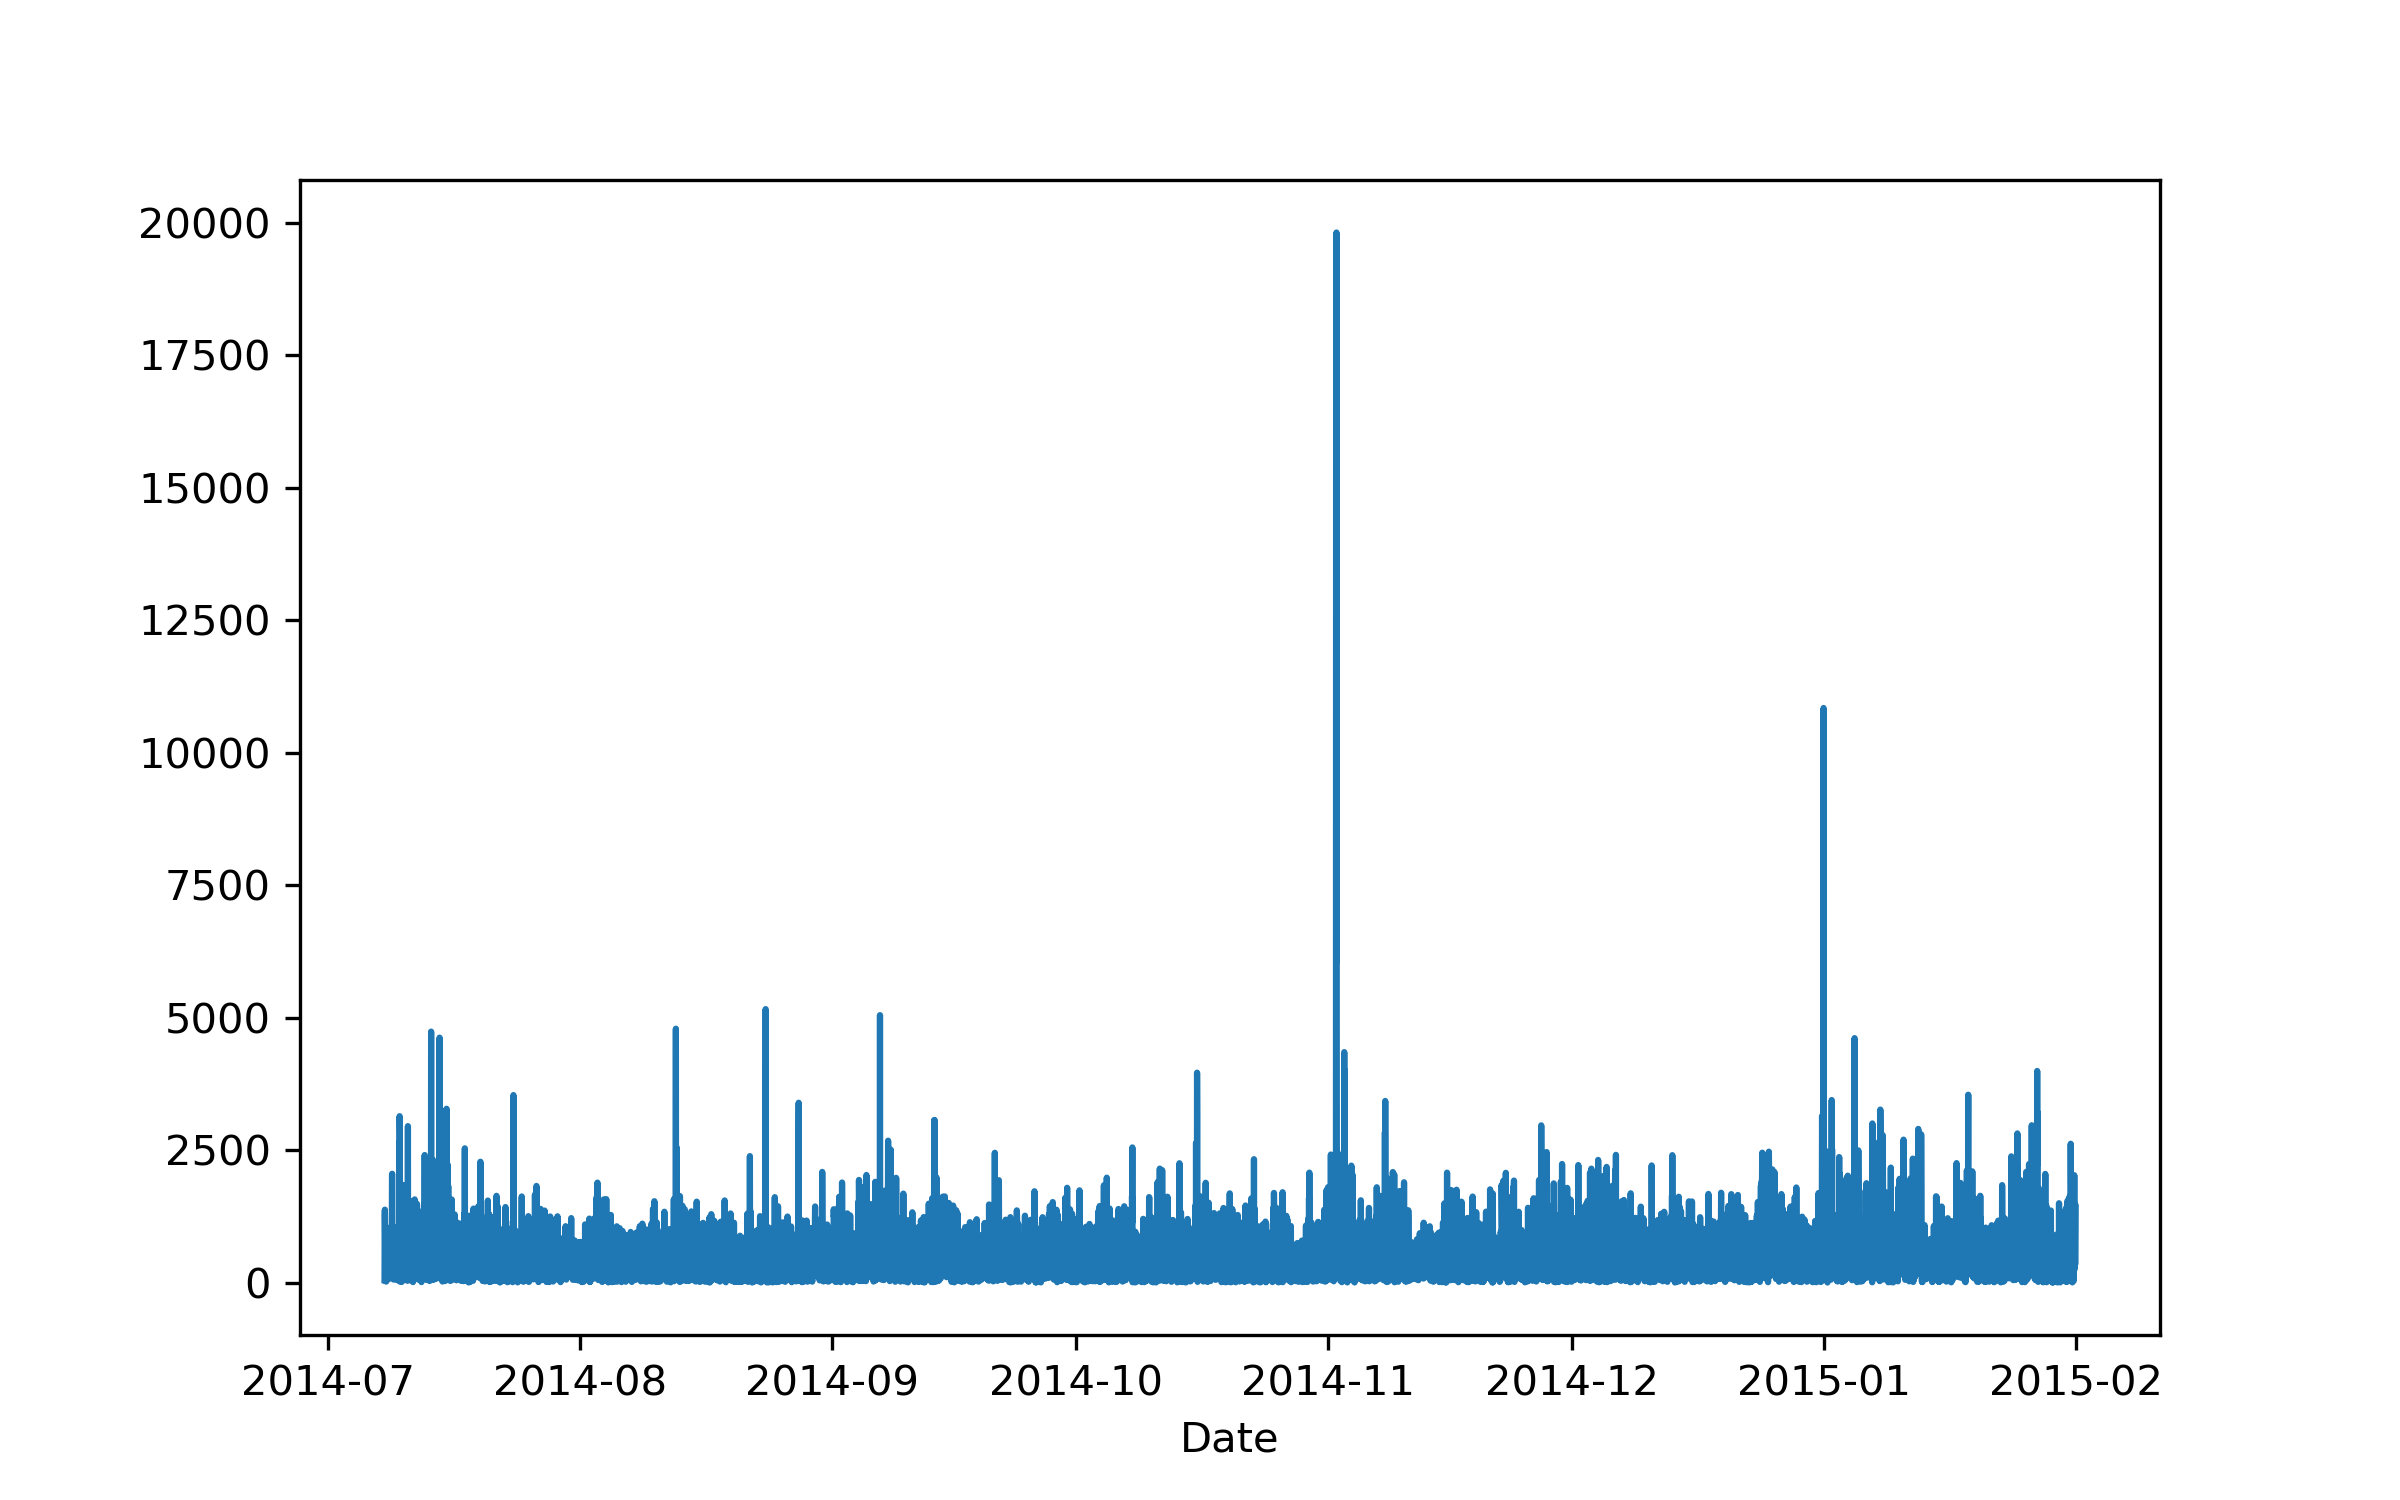

In [12]:
# Prediction error with AR model
plt.figure("Prediction error with AR(336) model")
plt.plot(dates[p:],np.abs(x_hat-x[p:]))
plt.xlabel("Date")
plt.show()

Large prediction error values are likely to correspond to anomaly: it means that the samples cannot be predicted from past samples. Thresholding the prediction error can allow to isolate these unusual events.

In [13]:
# Anomaly detection by threholding the prediction error
error=np.abs(x_hat-x[p:])
thr=7500
ano_ind=np.where(error>thr)
ano=ano_ind[0]+p
print("Detected anomalies :")
for i in range(len(ano)):
    print(dates[ano[i]])
print("Annotated anomalies :")
for i in range(len(y)):
    print(y[i])

Detected anomalies :
2014-11-02 01:00:00
2014-11-02 02:00:00
2015-01-01 00:00:00
2015-01-01 00:30:00
Annotated anomalies :
2014-11-01 19:00:00
2014-11-27 15:30:00
2014-12-25 15:00:00
2015-01-01 01:00:00
2015-01-27 00:00:00


### 3.3. Distance-based anomaly detection

In [14]:
# Optimized implementation of sliding Euclidean distance with Mueen's algorithm
def fast_distance_profile_nEUC(x,p):
    c=np.cumsum(np.concatenate(([0],x)))
    c2=np.cumsum(np.concatenate(([0],x))**2)
    N=np.size(x)
    Np=np.size(p)
    p_=(p-np.mean(p))/np.std(p)
    p__=np.zeros((N,))
    p__[0:Np]=np.flip(p_)
    r=np.real(np.fft.ifft(np.multiply(np.fft.fft(x),np.fft.fft(p__))))
    vari=np.sqrt(Np * (c2[Np:-1]-c2[:N-Np]) -  (c[Np:-1]-c[:N-Np])**2)
    d=np.sqrt(np.maximum(2*Np*(1-np.divide(r[Np-1:N-1],vari)),0))
    return d

In [15]:
# Computes the matrix profile according to the normalized Euclidean distance
def matrix_profile(x,w):
    N=np.size(x)
    d=np.Inf*np.ones((N-w,))
    for i in range(N-w):
        x_=x[i:i+w]
        c=fast_distance_profile_nEUC(x,x_)
        c[np.maximum(0,int(i-w)):np.minimum(N-w,int(i+w))]=np.Inf
        d=np.minimum(d,c)
    return d

<IPython.core.display.Javascript object>


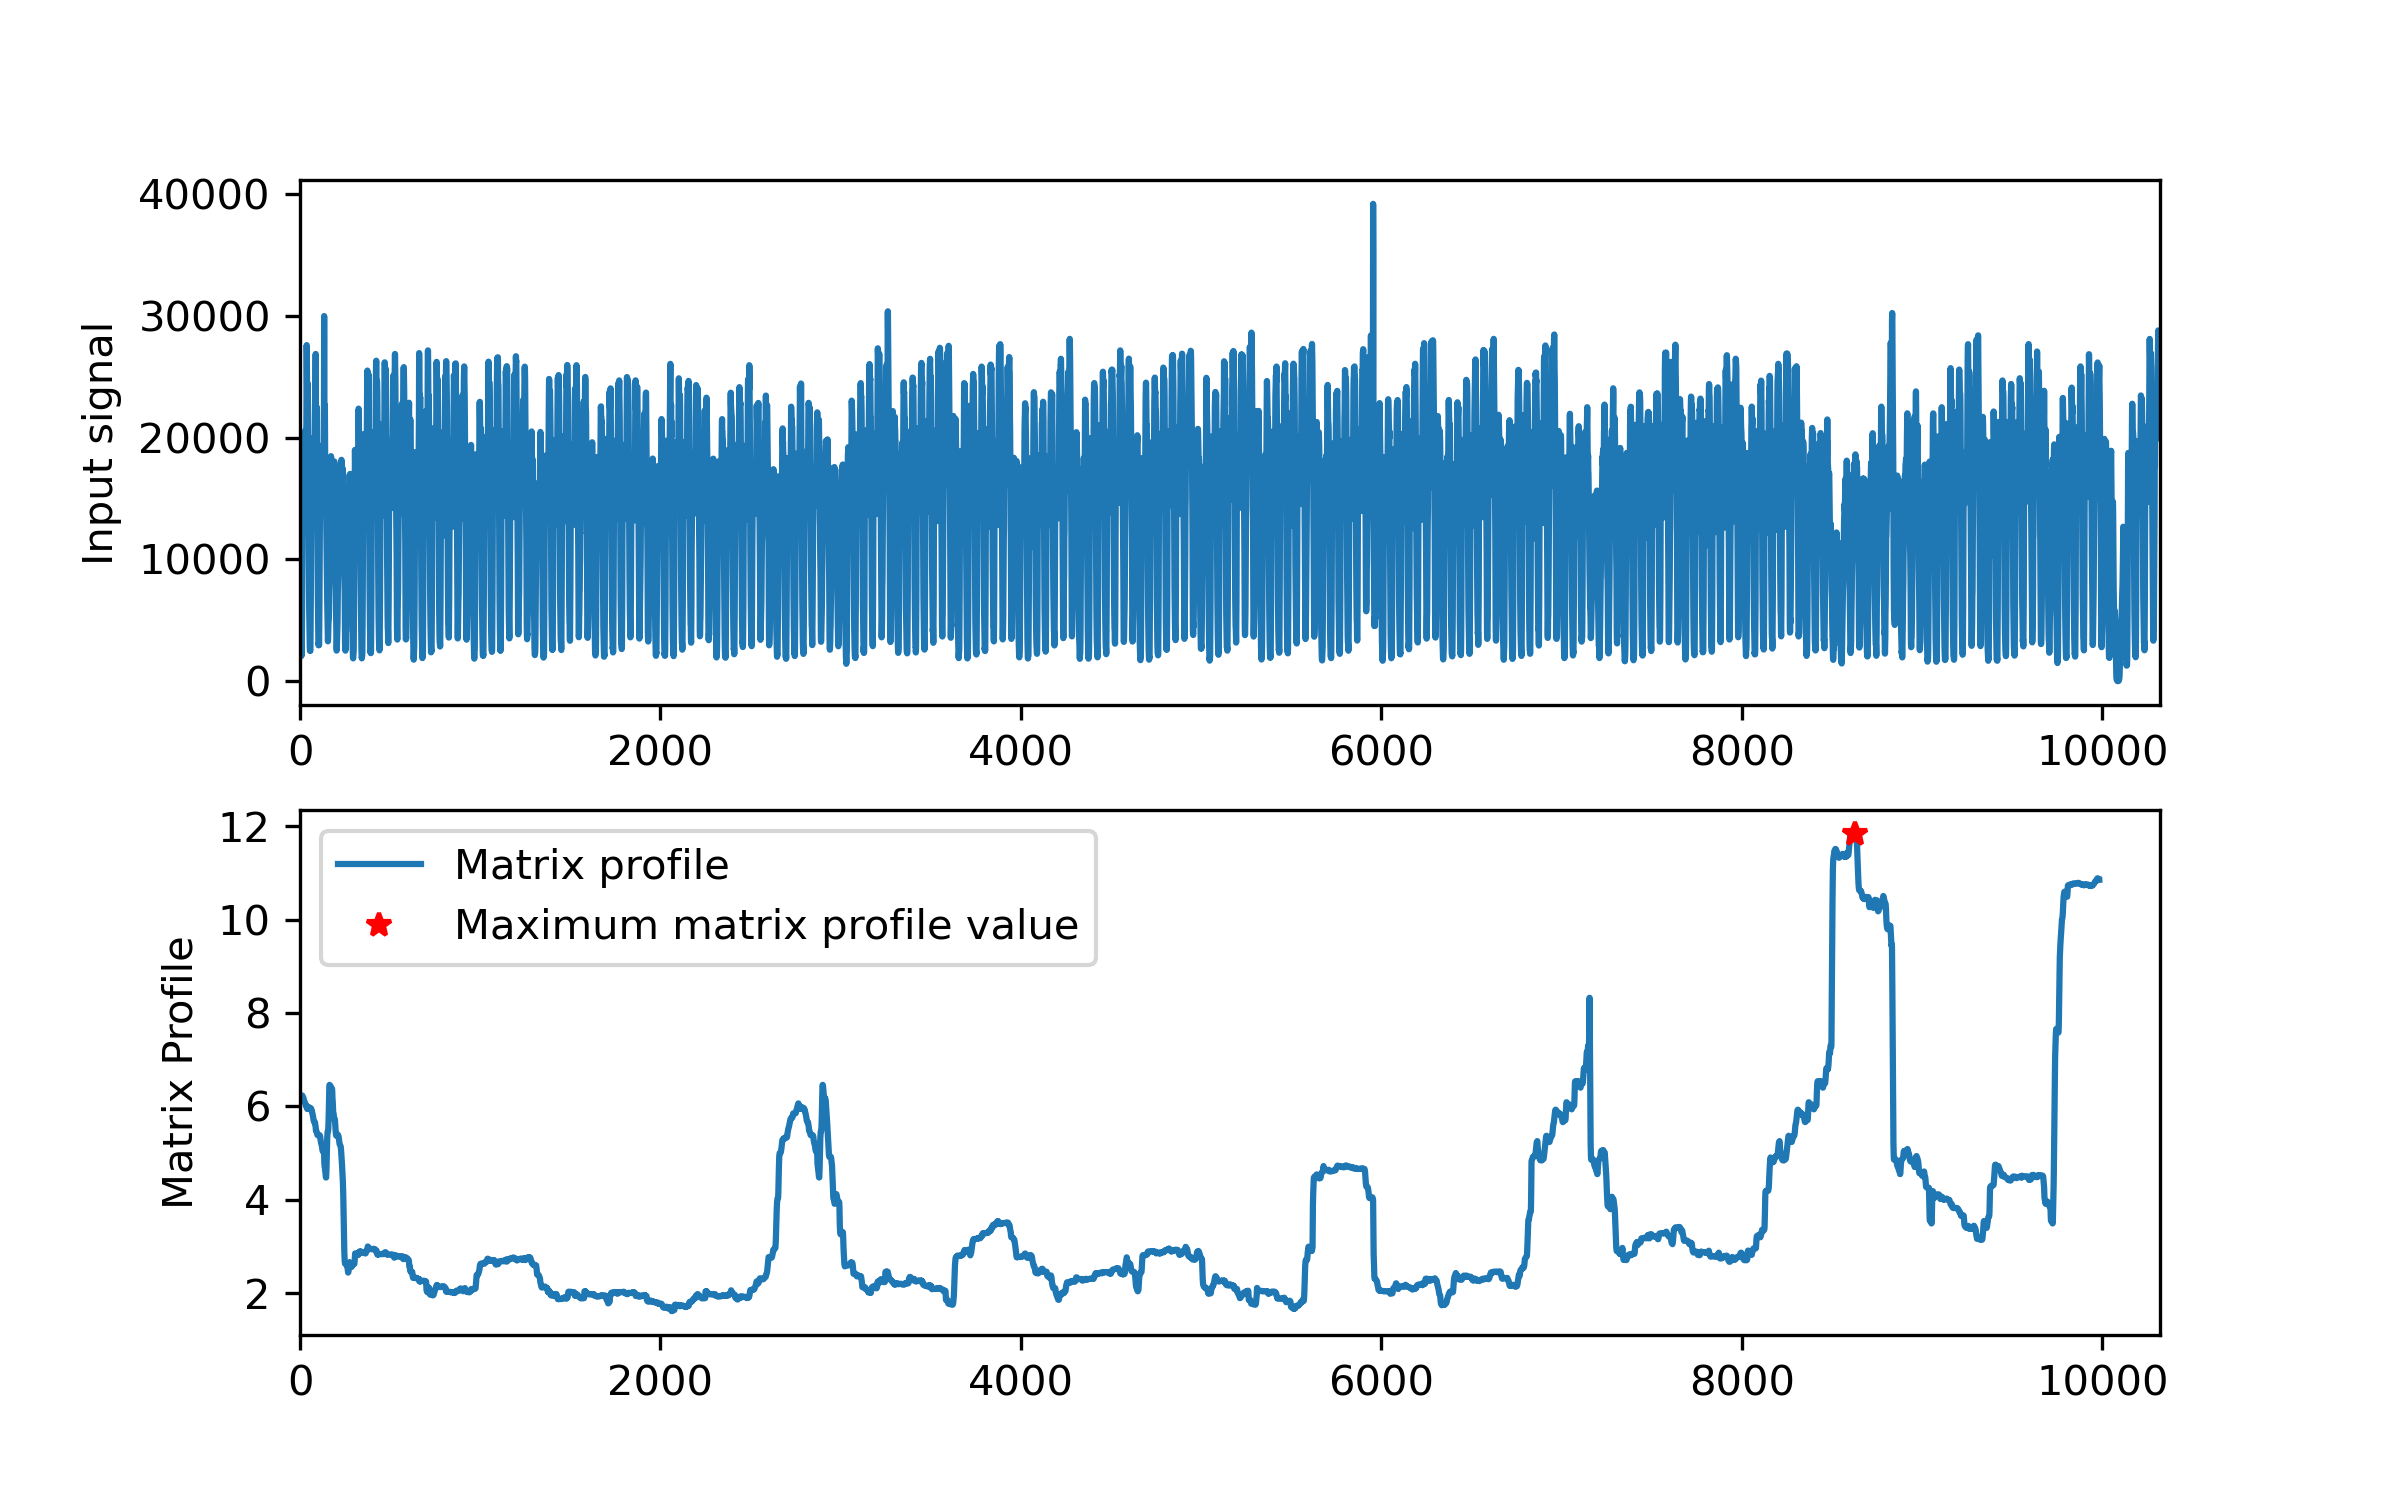

In [16]:
# Computation and plot of the matrix profile
L=336
m=matrix_profile(x,L)

plt.figure()
plt.subplot(2,1,1)
plt.plot(x)
plt.xlim([0,np.size(x)])
plt.ylabel('Input signal')
plt.subplot(2,1,2)
plt.plot(m)
plt.xlim([0,np.size(x)])
plt.ylabel('Matrix Profile')
ind=np.argmax(m)
plt.plot(ind,m[ind],'*r')
plt.legend(("Matrix profile","Maximum matrix profile value"))
plt.show()